In [10]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install matplotlib.pyplot

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [36]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('metrics.csv')
df = df.drop_duplicates(subset=['Type Name'])
df = df.drop(['Project.Package Name', 'Method Name', 'MLOC', 'CC', 'PC', 'Abstract Function Call From Constructor', 'Complex Conditional', 
              'Complex Method', 'Empty catch clause', 'Long Identifier', 'Long Method', 'Long Parameter List',
              'Long Statement', 'Missing default', 'Deficient encapsulation', 'Unexploited modularization',
             'Broken modularization', 'Cyclically-dependent modularization', 'Hub-like modularization', 'Insufficient modularization',
             'Broken hierarchy', 'Cyclic hierarchy', 'Deep hierarchy', 'Missing hierarchy','Missing hierarchy',
             'Multipath hierarchy', 'Rebellious hierarchy', 'Wide hierarchy'], axis=1)

df.set_index('Type Name', inplace = True)
train_data = df.values.tolist()
train_data = train_data[10000: 50000]

df[:10]

,NOF,NOPF,NOM,NOPM,LOC,WMC,NC,DIT,LCOM,FANIN,FANOUT,Magic Number
Type Name,,,,,,,,,,,,
CachedThreadPool,0,0,1,1,12,2,0,0,-1.0,0,0,1
Sleeper,1,0,2,2,21,2,0,0,0.0,0,0,0
Joiner,1,0,2,2,17,2,0,0,0.0,0,0,0
Joining,0,0,1,1,7,1,0,0,-1.0,0,0,1
FixedThreadPool,0,0,1,1,12,2,0,0,-1.0,0,0,1
Interrupting,1,0,2,1,21,2,0,0,0.0,1,1,1
SleepBlocked,0,0,1,1,14,1,0,0,-1.0,0,0,1
IOBlocked,1,0,2,2,21,3,0,0,0.0,0,0,0
SynchronizedBlocked,0,0,4,4,18,5,0,0,-1.0,0,0,0


In [113]:
train_data

[[0.0, 0.0, 1.0, 1.0, 12.0, 2.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 2.0, 2.0, 21.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 2.0, 2.0, 17.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 7.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 12.0, 2.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 2.0, 1.0, 21.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 14.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 2.0, 2.0, 21.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 4.0, 4.0, 18.0, 5.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 12.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0],
 [2.0, 0.0, 6.0, 6.0, 23.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [3.0, 0.0, 2.0, 2.0, 22.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [2.0, 0.0, 2.0, 2.0, 21.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [2.0, 0.0, 2.0, 2.0, 21.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [2.0, 0.0, 2.0, 2.0, 25.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 15.0, 2.0, 0.

In [37]:
train_x = df.iloc[10000:50000,0:11]
train_y = df.iloc[10000:50000,11:12]
test_x = df.iloc[:10000,0:11]
test_y = df.iloc[:10000,11:12]
train_x


,NOF,NOPF,NOM,NOPM,LOC,WMC,NC,DIT,LCOM,FANIN,FANOUT
Type Name,,,,,,,,,,,
CancellableThread,1,0,5,5,34,6,0,0,0.600000,0,0
ArrayIterator,2,0,4,4,21,4,0,0,0.500000,0,0
DisjointSets,3,0,12,12,120,23,0,0,0.333333,1,0
IdentityHashSet,1,0,2,2,9,2,0,0,1.000000,0,0
JavaRandomizer,2,0,3,3,17,3,0,1,0.666667,0,0
...,...,...,...,...,...,...,...,...,...,...,...
MovieBean,2,0,4,4,19,4,0,0,0.000000,0,0
ContractsBean,1,0,2,2,12,2,0,0,0.000000,0,0
Flow1Bean,0,0,3,3,14,3,0,0,-1.000000,0,0


In [33]:
from sklearn.decomposition import PCA

mypca = PCA(n_components = 2)
PCA_train_x = mypca.fit_transform(train_x)

In [ ]:
print('PCA_train_x shape: ', PCA_train_x.shape)

Text(0, 0.5, 'Principal Component 2')

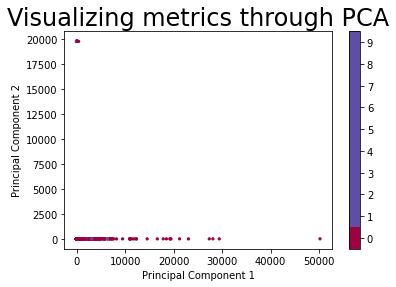

In [13]:
## Plot on the graph
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], s = 5, c = train_y['Magic Number'], cmap = 'Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

plt.title('Visualizing metrics through PCA', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [14]:
sub_PCA_train_x = PCA_train_x[:10000, :]
print('sub_PCA_train_x.shape: ', sub_PCA_train_x.shape)

sub_PCA_train_x.shape:  (10000, 2)


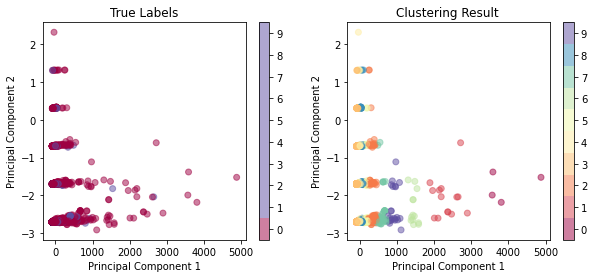

In [15]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

hier = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean')
hier_clusters = hier.fit(sub_PCA_train_x)

## Plot 
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c = train_y['Magic Number'][:10000], cmap = 'Spectral', alpha = 0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("True Labels")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c=hier_clusters.labels_[:10000], cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("Clustering Result ")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Apply k-means

In [16]:
def apply_normalizer(dataset, offset, divisor):
    dataset_normalized = np.zeros(dataset.shape)
    N = dataset.shape[0]
    dataset_normalized = dataset-np.tile(offset, (N,1))
    dataset_normalized = dataset_normalized / np.tile(divisor, (N,1))

    return dataset_normalized


def normalize_minmax(dataset):
    minval = dataset.min(0)
    maxval = dataset.max(0)
    
    dataset_normalized = apply_normalizer(dataset, minval, maxval-minval)

    return dataset_normalized, minval, maxval-minval


def normalize_meanstd(dataset):
    meanval = dataset.mean(0)
    stdval = dataset.std(0)

    dataset_normalized = apply_normalizer(dataset, meanval, stdval)

    return dataset_normalized, meanval, stdval



In [17]:
normalized_PCA_train_x, off, div = normalize_minmax(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div, '\n')

normalized_PCA_train_x, off, div = normalize_meanstd(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div)

Original data:  [-76.14270542  -2.69774375] 
Normalized data:  [0.00181856 0.04048943]
offset: [-85.1691626   -2.90904193] ;  divisor: [4963.5185992     5.21860087] 

Original data:  [-76.14270542  -2.69774375] 
Normalized data:  [-0.31997266 -0.45249748]
offset: [-24.58403324  -2.43815123] ;  divisor: [161.13461638   0.57368832]


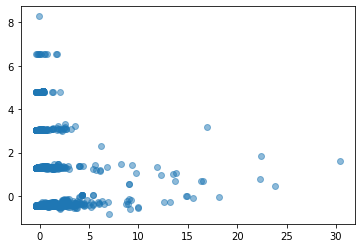

In [18]:
plt.scatter(normalized_PCA_train_x[:, 0], normalized_PCA_train_x[:, 1], cmap='Spectral', alpha=0.5)

In [19]:
# a distance function
def Euclidean_distance(vecA, vecB):
    return np.sqrt(sum(np.power([a - b for a, b in zip(vecA, vecB)], 2)))

In [20]:
k = int(input("How many cluster do you want? "))
print(k)

How many cluster do you want? 3
3


In [22]:
import random

def init_centroids_random(dataset, k):
    centroids = {}
    init_centroids = random.sample(range(0, len(dataset)), k)
    
    for i, c in enumerate(init_centroids):
            centroids[i] = dataset[i]
    return centroids

In [23]:
def init_centroids_index(dataset, k):
    centroids = {}
    for i in range(k):  # first k instances become the initial centroids
        centroids[i] = dataset[i]
    return centroids

In [24]:
# initialize_centroids(centroids, sub_PCA_train_x)
centroids = init_centroids_random(sub_PCA_train_x, k)

In [25]:
# Change centroids value to dataframe. 
cet_df = pd.DataFrame(centroids).transpose()
cet_df.columns = ['X', 'Y']
cet_df.head()

,X,Y
0,-76.142705,-2.697744
1,-67.176452,-2.697644
2,-71.067691,-2.697141


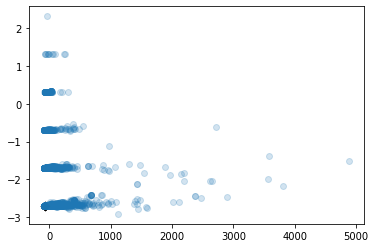

In [26]:
# Plot random centroids on the dataset
plt.figure()
plt.scatter(cet_df['X'], cet_df['Y'], color='black', marker='D')
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], alpha=0.2)

In [27]:
def re_assign_data(dataset, centroids):
    # (Re)assigning every instance to its closest centroid
    cluster_memberships = {}
    for i in centroids:
        cluster_memberships[i] = []
    
    for row in dataset:
        # Calculate euclidean distance between each centroid and each data.
        dist_to_centroids = [Euclidean_distance(row, centroids[c]) for c in centroids]
        
        # Find the centroid with a minimum distance 
        membership = dist_to_centroids.index(min(dist_to_centroids))
        cluster_memberships[membership].append(row)
        
    return cluster_memberships

In [28]:
def re_calc_avg_sse(centroids, cluster_memberships):    
    # Re-calculate the average of each cluster and calculate SSE.
    curr_sse = 0
    
    for membership in cluster_memberships:
        centroids[membership] = np.average(cluster_memberships[membership], axis=0)

        for row in cluster_memberships[membership]:
            curr_sse += np.power(Euclidean_distance(row, centroids[membership]), 2)
    
    return centroids, curr_sse 

In [29]:
## k-Means algorithm
def kmeans(dataset, k, max_iter = 300, tol = 0.001):
    centroids = init_centroids_random(dataset, k)
    
    ## 1. Initiate SSE which is key metric in k-means clustering (sse = sum of squared error) into 'np.inf'
    curr_sse = np.inf
    

    ## 2. Clustering
    for i in range(max_iter):

        ## (Re)Aassign datas to its closest centroids
        cluster_memberships = re_assign_data(dataset, centroids)

        ## Re-calculate the average of each cluster and calculate SSE.
        prev_sse = curr_sse
        centroids, curr_sse = re_calc_avg_sse(centroids, cluster_memberships)

        ## Plot center points
        plt.figure(i)
        c_df = pd.DataFrame(centroids).transpose()
        plt.scatter(c_df.loc[:, 0], c_df.loc[:, 1], color='black', marker='x')

        ## Plot assigned data
        for key in cluster_memberships:
            plt.scatter(*zip(*cluster_memberships[key]), alpha=0.2)
            plt.title('k={} '.format(k) + ' SSE=' + str(curr_sse))

        plt.show()
        print('iteration#{} | prev_sse= {:.4f};  curr_sse= {:.4f}'.format(i, prev_sse, curr_sse))

        # Terminal Condition
        if (prev_sse - curr_sse) / curr_sse < tol:
            break

    return cluster_memberships, curr_sse

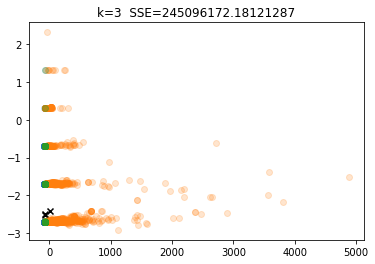

iteration#0 | prev_sse= inf;  curr_sse= 245096172.1812


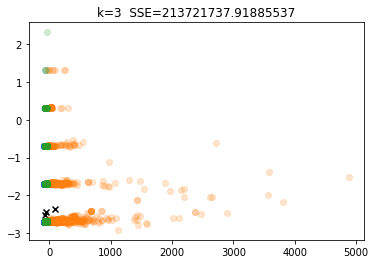

iteration#1 | prev_sse= 245096172.1812;  curr_sse= 213721737.9189


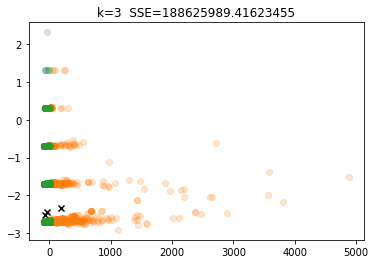

iteration#2 | prev_sse= 213721737.9189;  curr_sse= 188625989.4162


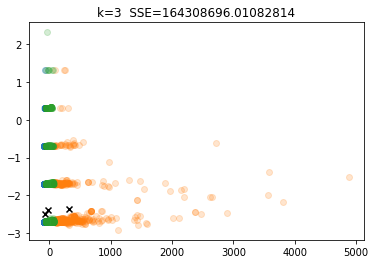

iteration#3 | prev_sse= 188625989.4162;  curr_sse= 164308696.0108


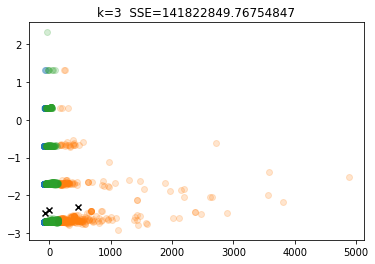

iteration#4 | prev_sse= 164308696.0108;  curr_sse= 141822849.7675


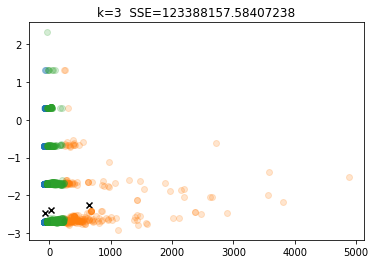

iteration#5 | prev_sse= 141822849.7675;  curr_sse= 123388157.5841


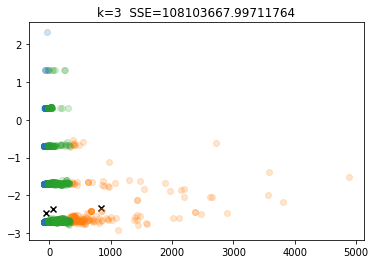

iteration#6 | prev_sse= 123388157.5841;  curr_sse= 108103667.9971


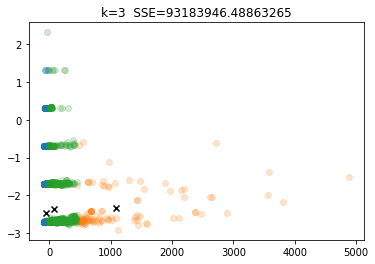

iteration#7 | prev_sse= 108103667.9971;  curr_sse= 93183946.4886


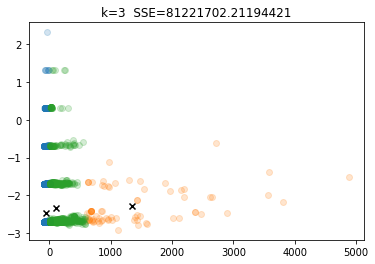

iteration#8 | prev_sse= 93183946.4886;  curr_sse= 81221702.2119


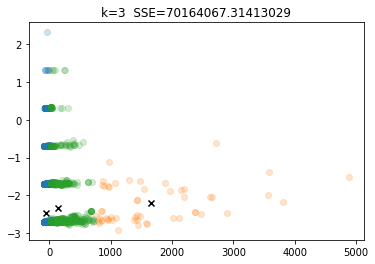

iteration#9 | prev_sse= 81221702.2119;  curr_sse= 70164067.3141


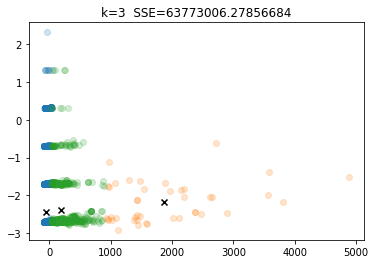

iteration#10 | prev_sse= 70164067.3141;  curr_sse= 63773006.2786


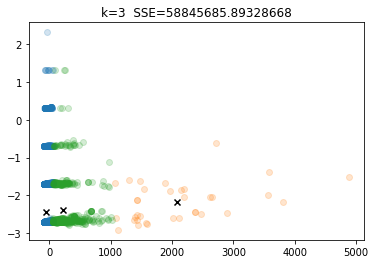

iteration#11 | prev_sse= 63773006.2786;  curr_sse= 58845685.8933


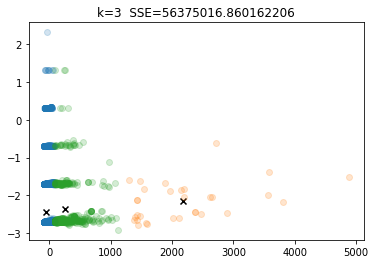

iteration#12 | prev_sse= 58845685.8933;  curr_sse= 56375016.8602


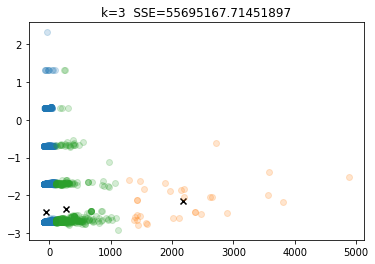

iteration#13 | prev_sse= 56375016.8602;  curr_sse= 55695167.7145


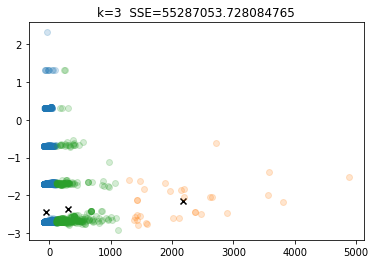

iteration#14 | prev_sse= 55695167.7145;  curr_sse= 55287053.7281


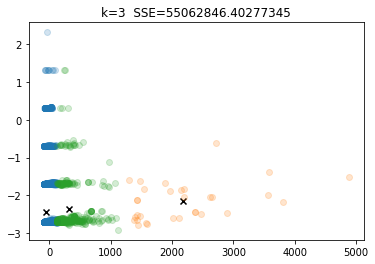

iteration#15 | prev_sse= 55287053.7281;  curr_sse= 55062846.4028


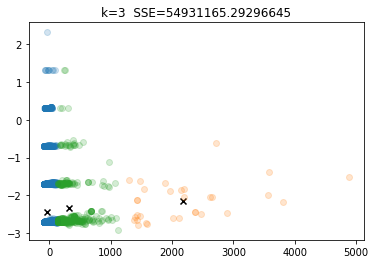

iteration#16 | prev_sse= 55062846.4028;  curr_sse= 54931165.2930


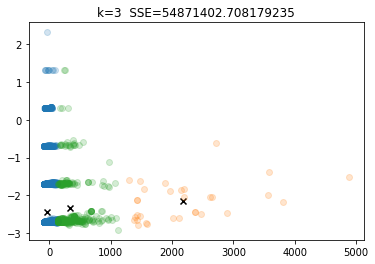

iteration#17 | prev_sse= 54931165.2930;  curr_sse= 54871402.7082


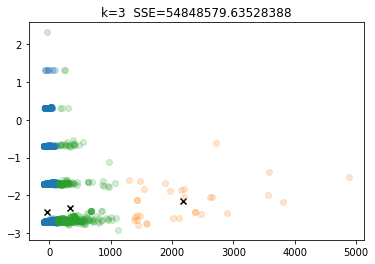

iteration#18 | prev_sse= 54871402.7082;  curr_sse= 54848579.6353


In [30]:
cluster_memberships, curr_sse = kmeans(sub_PCA_train_x, k)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [3]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset.
    rows: list of row data
    """
    counts = {}  # a dictionary of label -> count.

    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[11]

        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [4]:
class_counts(train_data)

{0.0: 35766, 1.0: 4235}

In [5]:
def is_numeric(value):

    return isinstance(value, int) or isinstance(value, float)

In [6]:
class Question:
    ## Constructor
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def compare_with_question(self, example):
        '''
        Arguments:
        example -- List of row data (EX. ['Blue', 2, 'Blueberry'])
        '''
        val = example[self.column]

        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    # Python __repr__() function returns the object representation in string format.
    def __repr__(self):
        condition = "=="

        if is_numeric(self.value):
            condition = ">="
        return "Is {} {} {}?".format(columns[self.column], condition, str(self.value))

In [7]:
columns = ['NOF', 'NOPF','NOM','NOPM','LOC','WMC','NC','DIT','LCOM','FANIN', 'FANOUT','Magic Number']

In [8]:
Question(8, 0)

Is LCOM >= 0?

In [9]:
def partition(rows, question):
    """Partitions a dataset
    Arguments:
    rows -- List of row data
    question -- An object of Question class
    """

    true_rows, false_rows = [], []

    for row in rows:
        if question.compare_with_question(row):
            true_rows.append(row)
        else:
            false_rows.append(row)

    return true_rows, false_rows

In [10]:
true_rows, false_rows = partition(train_data, Question(8, 0))

In [40]:
# print("The true_rows\n ===> ", true_rows, "\nThe false_rows\n ===> ", false_rows)

In [15]:
import numpy as np
from math import log2, e

In [16]:
## JUST RUN IT!
def entropy(labels, base=None):
    """ Computes entropy of label distribution. 
    Arguments:
    labels -- Lists of data's label 
    """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    counts = class_counts(labels) # return "dict{class_label : counts}"
    probs = [counts[key]/n_labels for key in counts.keys()]

    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    # base = e if base is None else base
    for i in probs:
        ent -= i * log2(i)

    return ent

In [17]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    IG = The uncertainty of the starting node - the weighted impurity of two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    
#     print("(1) Avg of Impurity = {:.4f} * {:.4f} + {:.4f} * {:.4f}".format(p, entropy(left), 
#                                                                            (1-p), entropy(right)))
#     print("(2) Current uncertainty = {:.4f}".format(current_uncertainty))

    
    IG = current_uncertainty - (p * entropy(left) + (1 - p) * entropy(right))
#     print("(3) Information gain = {:.4f} - ({:.4f} * {:.4f} + {:.4f} * {:.4f})= {:.4f}\n".
#           format(current_uncertainty, p, entropy(left), 1-p, entropy(right), IG))

    return IG

In [18]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset.
    rows: list of row data
    """
    counts = {}  # a dictionary of label -> count.

    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]

        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [19]:
current_uncertainty = entropy(train_data)
print("\nCurrent uncertainty ===> {:.4f}".format(current_uncertainty))


Current uncertainty ===> 0.4873


In [20]:
print('Question? ', Question(8, 0))

true_rows, false_rows = partition(train_data, Question(3, 10))
# print("True_rows ===> {}".format(true_rows[:10]))
# print("False rows ===> {}\n".format(false_rows))

print("\nThe information gain by partitioning on \"diameter >= 3\" is {:.4f}".format(info_gain(true_rows, false_rows, current_uncertainty)))

Question?  Is LCOM >= 0?

The information gain by partitioning on "diameter >= 3" is 0.0000


In [21]:
def find_best_split(rows):

    best_gain = 0
    best_question = None

    current_uncertainty = entropy(rows)
    n_features = len(rows[0]) - 1

    for col in range(n_features):

        values = set([row[col] for row in rows])

        for val in values:

            question = Question(col, val)

            true_rows, false_rows = partition(rows, question)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

#             print('Qustion ====>>> ', question)
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [22]:
best_gain, best_question = find_best_split(train_data)

print("The best question ====>>>>> ", best_question)

The best question ====>>>>>  Is NOF >= 1.0?


In [23]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        ## 'self.predictions' is a dictionary of class counts.
        self.predictions = class_counts(rows)

In [24]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
               question,
               true_branch,
               false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [25]:
def build_tree(rows):
    """Builds the tree.
    Arguments:
    rows --- List of row data
    """
    gain, question = find_best_split(rows)

    ## If information gain is equal to 0, just return the Leaf object.
    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    ## Make additional tree nodes
    true_branch = build_tree(true_rows)

    false_branch = build_tree(false_rows)

    return Decision_Node(question, true_branch, false_branch)

In [26]:
def print_tree(node, spacing=""):
    """Tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [27]:
my_tree = build_tree(train_data)

In [29]:
# print_tree(my_tree)

In [59]:
def classify(row, node):

    ## If this node is Leaf, return predicted results.
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.compare_with_question(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [60]:
## Return the each class counts
classify(train_data[0], my_tree)

{0.0: 10}

In [61]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}

    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
        
    return probs

In [62]:
print_leaf(classify(train_data[0], my_tree))

{0.0: '100%'}

In [38]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(random_state=0)
rforest.fit(train_x, train_y.values.ravel())

RandomForestClassifier(random_state=0)

In [40]:
print("Test set score : {:.2f}".format(rforest.score(test_x, test_y)))

Test set score : 0.83


In [42]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(random_state=0)
decisionTree.fit(train_x, train_y.values.ravel())

DecisionTreeClassifier(random_state=0)

In [43]:
print("Test set score : {:.2f}".format(decisionTree.score(test_x, test_y)))

Test set score : 0.79


In [44]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


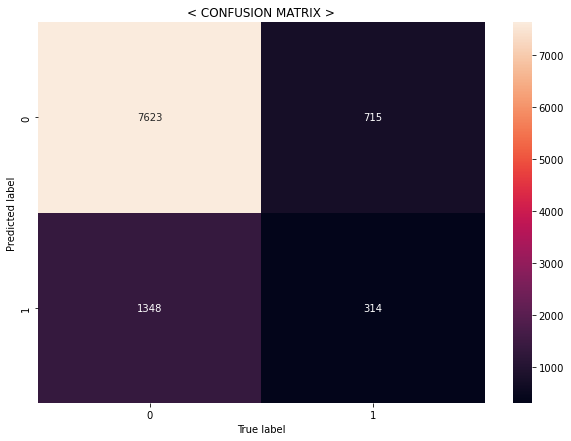

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

pred_y = decisionTree.predict(test_x)
cmdtree = confusion_matrix(test_y, pred_y)

plt.figure(figsize=(10, 7))
sn.heatmap(cmdtree, annot=True, fmt='d')

plt.title("< CONFUSION MATRIX >")
plt.ylabel('Predicted label')
plt.xlabel('True label')

plt.show()

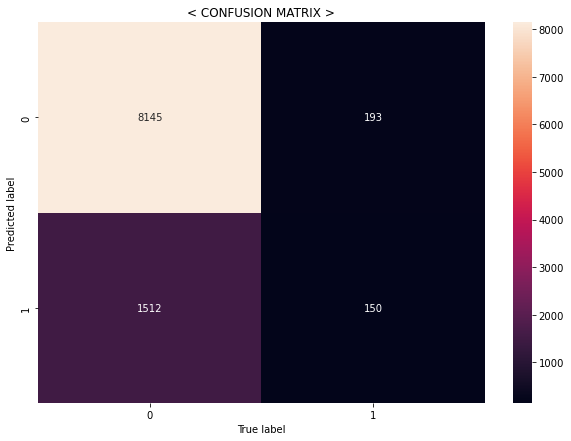

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

pred_y = rforest.predict(test_x)
rtree_cmd = confusion_matrix(test_y, pred_y)

plt.figure(figsize=(10, 7))
sn.heatmap(rtree_cmd, annot=True, fmt='d')

plt.title("< CONFUSION MATRIX >")
plt.ylabel('Predicted label')
plt.xlabel('True label')

plt.show()

In [48]:
train_x2 = df.iloc[50000:100000,0:11]
train_y2 = df.iloc[50000:100000,11:12]
test_x2 = df.iloc[:20000,0:11]
test_y2 = df.iloc[:20000,11:12]

In [54]:
rforest2 = RandomForestClassifier(random_state=0)
rforest2.fit(train_x2, train_y2.values.ravel())

RandomForestClassifier(random_state=0)

In [55]:
print("Test set score : {:.2f}".format(rforest2.score(test_x2, test_y2)))

Test set score : 0.86


In [53]:
decisionTree = DecisionTreeClassifier(random_state=0)
decisionTree.fit(train_x2, train_y2.values.ravel())

DecisionTreeClassifier(random_state=0)

In [56]:
print("Test set score : {:.2f}".format(decisionTree.score(test_x2, test_y2)))

Test set score : 0.89


In [58]:
# 4만개 train set과 2만개 test set

rforest3 = RandomForestClassifier(random_state=0)
rforest3.fit(train_x, train_y.values.ravel())

RandomForestClassifier(random_state=0)

In [59]:
print("Test set score : {:.2f}".format(rforest3.score(test_x2, test_y2)))

Test set score : 0.91
